# Problema de negócio

**Análise de vendas de filiais de lojas de supermercado**

Analisando as vendas das lojas e sua dependência da área das lojas e da contagem diária de clientes

**Contexto**

Um supermercado é uma loja de autoatendimento que oferece uma grande variedade de alimentos, bebidas e produtos domésticos, organizados em seções. Esse tipo de loja é maior e tem uma seleção mais ampla do que as mercearias anteriores, mas é menor e mais limitada na variedade de mercadorias do que um hipermercado ou um grande mercado. No uso diário dos EUA, no entanto, "mercearia" é sinônimo de supermercado e não é usado para se referir a outros tipos de lojas que vendem mantimentos.

[https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount](https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount)

**Como o problema é resolvido atualmente ?**

    Os analistas de negócio usam a média das últimas vendas para estimar as próximas nas filiais em destaque.

    Baseline = Média das últimas vendas

    Deve-se calcular o erro que a atual solução traz e o seu custo financeiro

    Alavancas ( aumento de vendas, redução de stockout, redução de custos, aumento de faturamento, previsão de demanda)

# Entendimento dos dados

No conjunto de dados, você obterá dados de diferentes lojas de uma empresa de supermercado de acordo com seus IDs de loja que, para facilitar, foram convertidos em números inteiros positivos.

**ID da loja:** (Índice) ID da loja específica.

**Store_Area:** Área Física da loja em metro quadrado.

**Items_Available:** Número de diferentes itens disponíveis na loja correspondente.

**Daily_Customer_Count:** número de clientes que visitaram as lojas em média ao longo do mês.

**Store_Sales:** Vendas em (US$) que as lojas realizaram.

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import  Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor as lgb
from xgboost import XGBRegressor as xgb
from catboost import CatBoostRegressor as ctb

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import FeatureImportances


import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.catboost

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import os
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

# Separação dos dados

 - Separar treino e teste
 - A amostra de teste será a base de cálculo do ROI 
 - Para calcular o ROI o baseline será a média de vendas por filial simulando a forma como os analistas de negócio estimam as vendas da rede de supermercadossklearn.neural_network

In [2]:
path = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\raw\Stores.csv'

data = pd.read_csv(path, sep=';')

In [3]:
data.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [4]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [5]:
train.shape

(716, 5)

In [6]:
test.shape

(180, 5)

In [7]:
# ETL interim
#train.to_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\train.csv',index=False)
#test.to_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\test.csv',index=False)

# EDA 
 - Na amostra de treino apenas
 - O teste não será visto pois é para simular o ambiente em produção

In [8]:
df_train = pd.read_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\train.csv', sep=',')

In [9]:
df_train.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,737,1098,1309,860,59530
1,383,1454,1737,870,23090
2,707,1495,1793,1020,65300
3,818,1608,1962,770,36280
4,119,1500,1798,860,56710


In [10]:
# Sanit check

def sanit_check(df:pd.DataFrame):

    print(f'Número de linhas: {df.shape[0]} \n')
    print(f'Número de colunas {df.shape[1]} \n')
    print(f'Número de linhas duplicadas: {df.duplicated().sum()}\n')
    print(f'Número de linhas nulas:\n {df.isnull().sum()}')

    return None

In [11]:
sanit_check(df_train)

Número de linhas: 716 

Número de colunas 5 

Número de linhas duplicadas: 0

Número de linhas nulas:
 Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64


Não há dados duplicados ou nulos !

<Axes: >

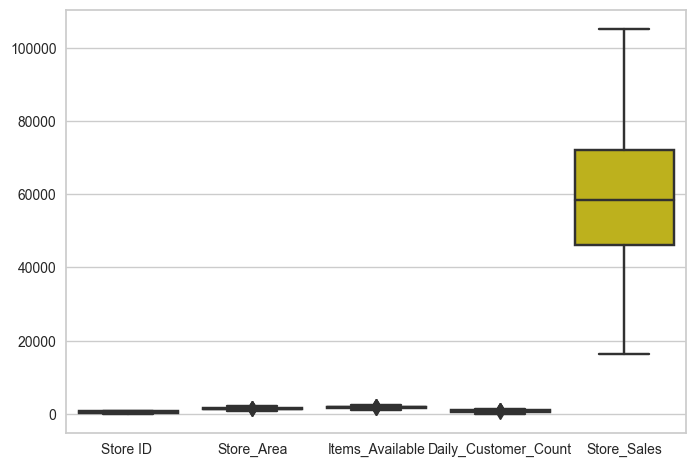

In [12]:
# Check outliers
sns.boxplot(df_train)

Aparentemente não temos outliers nos dados de treino

In [13]:
df_train.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,716.000000,716.000000,716.000000,716.000000,716.000000
mean,450.437151,1482.632682,1778.560056,785.237430,59170.377095
std,257.862012,251.766360,301.446876,259.725136,17357.070464
min,1.000000,775.000000,932.000000,70.000000,16370.000000
25%,225.750000,1315.500000,1571.000000,610.000000,46190.000000
50%,456.500000,1472.000000,1763.000000,770.000000,58385.000000
75%,675.500000,1648.250000,1981.250000,950.000000,72127.500000
max,896.000000,2229.000000,2667.000000,1560.000000,105150.000000


Achados da descritiva acima:

    - Store_Area, Items_Available,	Daily_Customer_Count têm um leve desvio padrão considerando a distância entre os valores máximos e minimos destas variáveis
    - Store_Sales tem um desvio padrão maior, acredito que esta target não tenha uma distribuição normal deve-se testar esta hipótese mais tarde
    - A venda máxima diária foi de $ 105.150,00 e a minima de $ 16.370,00

# Hipóteses de negócio

### 1 - Quanto maior a área física da loja maior as vendas !

<Axes: xlabel='Store_Area', ylabel='Store_Sales'>

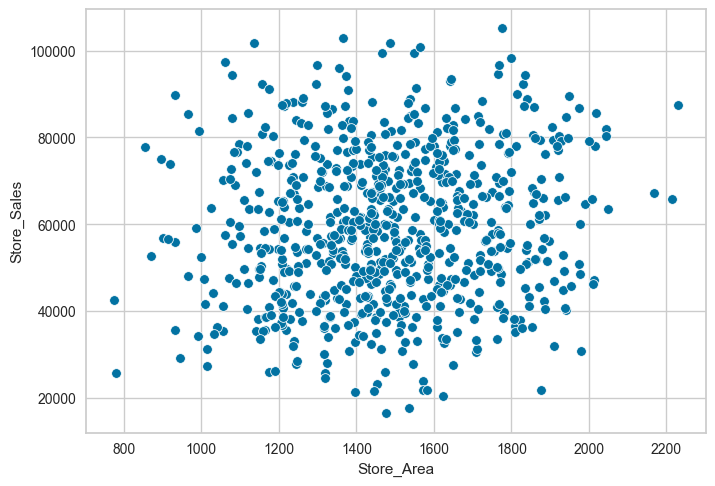

In [14]:
sns.scatterplot(x=df_train['Store_Area'], y=df_train['Store_Sales'])

- Analisando o gráfico aparenta ser falsa esta hipótese, não vejo uma relação linear forte entre os dados

- As maiores vendas se concetram em lojas com 1200 a 1800 metros quadrados

In [15]:
# Testar a H0 de que há uma correlação linear entre a área física da loja e as vendas. 
from scipy.stats import pearsonr

In [16]:
corr, p_value = pearsonr(df_train['Store_Area'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.09928637110096922
Valor p: 0.007845391240498711


O valor p correspondente testa a hipótese nula de que não há correlação linear entre as duas variáveis. Se o valor p for menor que um nível de significância pré-definido (por exemplo, 0,05), isso indica que a hipótese nula pode ser rejeitada em favor da hipótese alternativa de que há uma correlação linear significativa entre as duas variáveis. O valor da correlação indica a direção e a magnitude da relação, ou seja, quanto maior a área física da loja, maior as vendas, mantidas as outras variáveis constantes.

H0 aceita ! Lembrando que correlação não é causalidade

### 2 - Quanto mais itens disponíveis na loja maior as vendas !

<Axes: xlabel='Items_Available', ylabel='Store_Sales'>

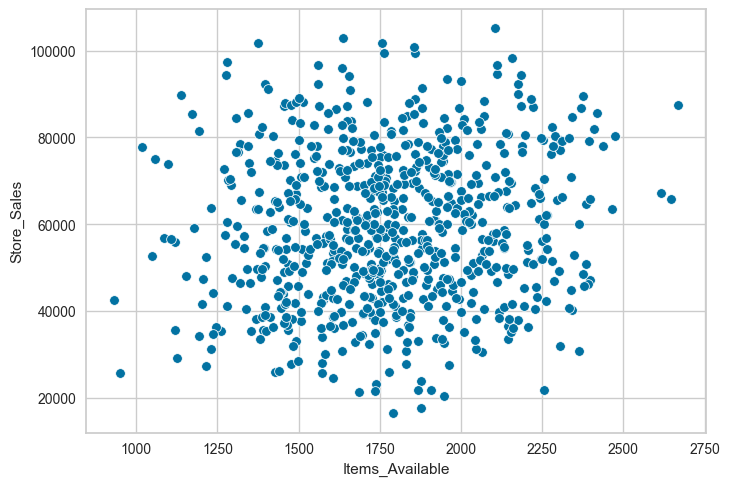

In [17]:
sns.scatterplot(x=df_train['Items_Available'], y=df_train['Store_Sales'])

- Os dados estão bastante dispersos também não há uma forte correlação entre a quantidade de itens para avaliação e o valor de vendas
- Os maiores valores de vendas se concetram na quantidade de itens para avaliação entre 1250 e 2250.

In [18]:
corr, p_value = pearsonr(df_train['Items_Available'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.10009049620048739
Valor p: 0.007355773008398902


H0 aceita ! Hipótese verdadeira.

### 3 - Quanto mais visitas na loja maior as vendas !

<Axes: xlabel='Daily_Customer_Count', ylabel='Store_Sales'>

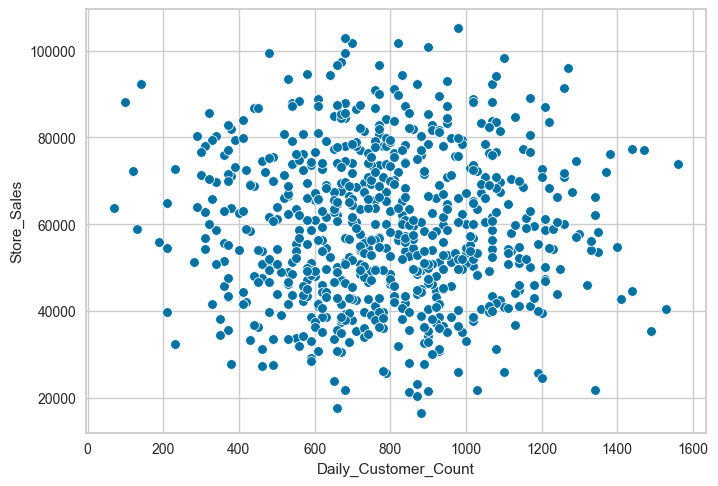

In [19]:
sns.scatterplot(x=df_train['Daily_Customer_Count'], y=df_train['Store_Sales'])

- Pelo gráfico tambem não temos uma forte correlação entre as variáveis
- Os maiores valores de vendas se concetram entre 600 e 1000 visitantes nas lojas

In [20]:
corr, p_value = pearsonr(df_train['Daily_Customer_Count'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: -0.01391553868890451
Valor p: 0.7100999525203255


H0 rejeitada ! Há uma correlação negativa entre as variáveis, quanto maior o número de visitantes menor é o valor de vendas.

    - Deve-se investigar o porquê e a causa, pois há um viés em pensarmos que quanto mais visitantes maiores as chances de compra, porém não é isto que oconteceu.
    - Será que quanto maior o número de visitantes pior é o atendimento ? Ou os clientes não gostam de esperar demais nas filas ? Deve-se investigar no campo !

# Análise Multivariada

In [21]:
# Verificar a correlação entre todas as variáveis 
corr = df_train.corr()

corr.style.background_gradient(cmap= 'coolwarm')

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store ID,1.000000,-0.090003,-0.086335,0.012928,0.079532
Store_Area,-0.090003,1.000000,0.998919,-0.050314,0.099286
Items_Available,-0.086335,0.998919,1.000000,-0.051089,0.100090
Daily_Customer_Count,0.012928,-0.050314,-0.051089,1.000000,-0.013916
Store_Sales,0.079532,0.099286,0.100090,-0.013916,1.000000


# Análise bivariada

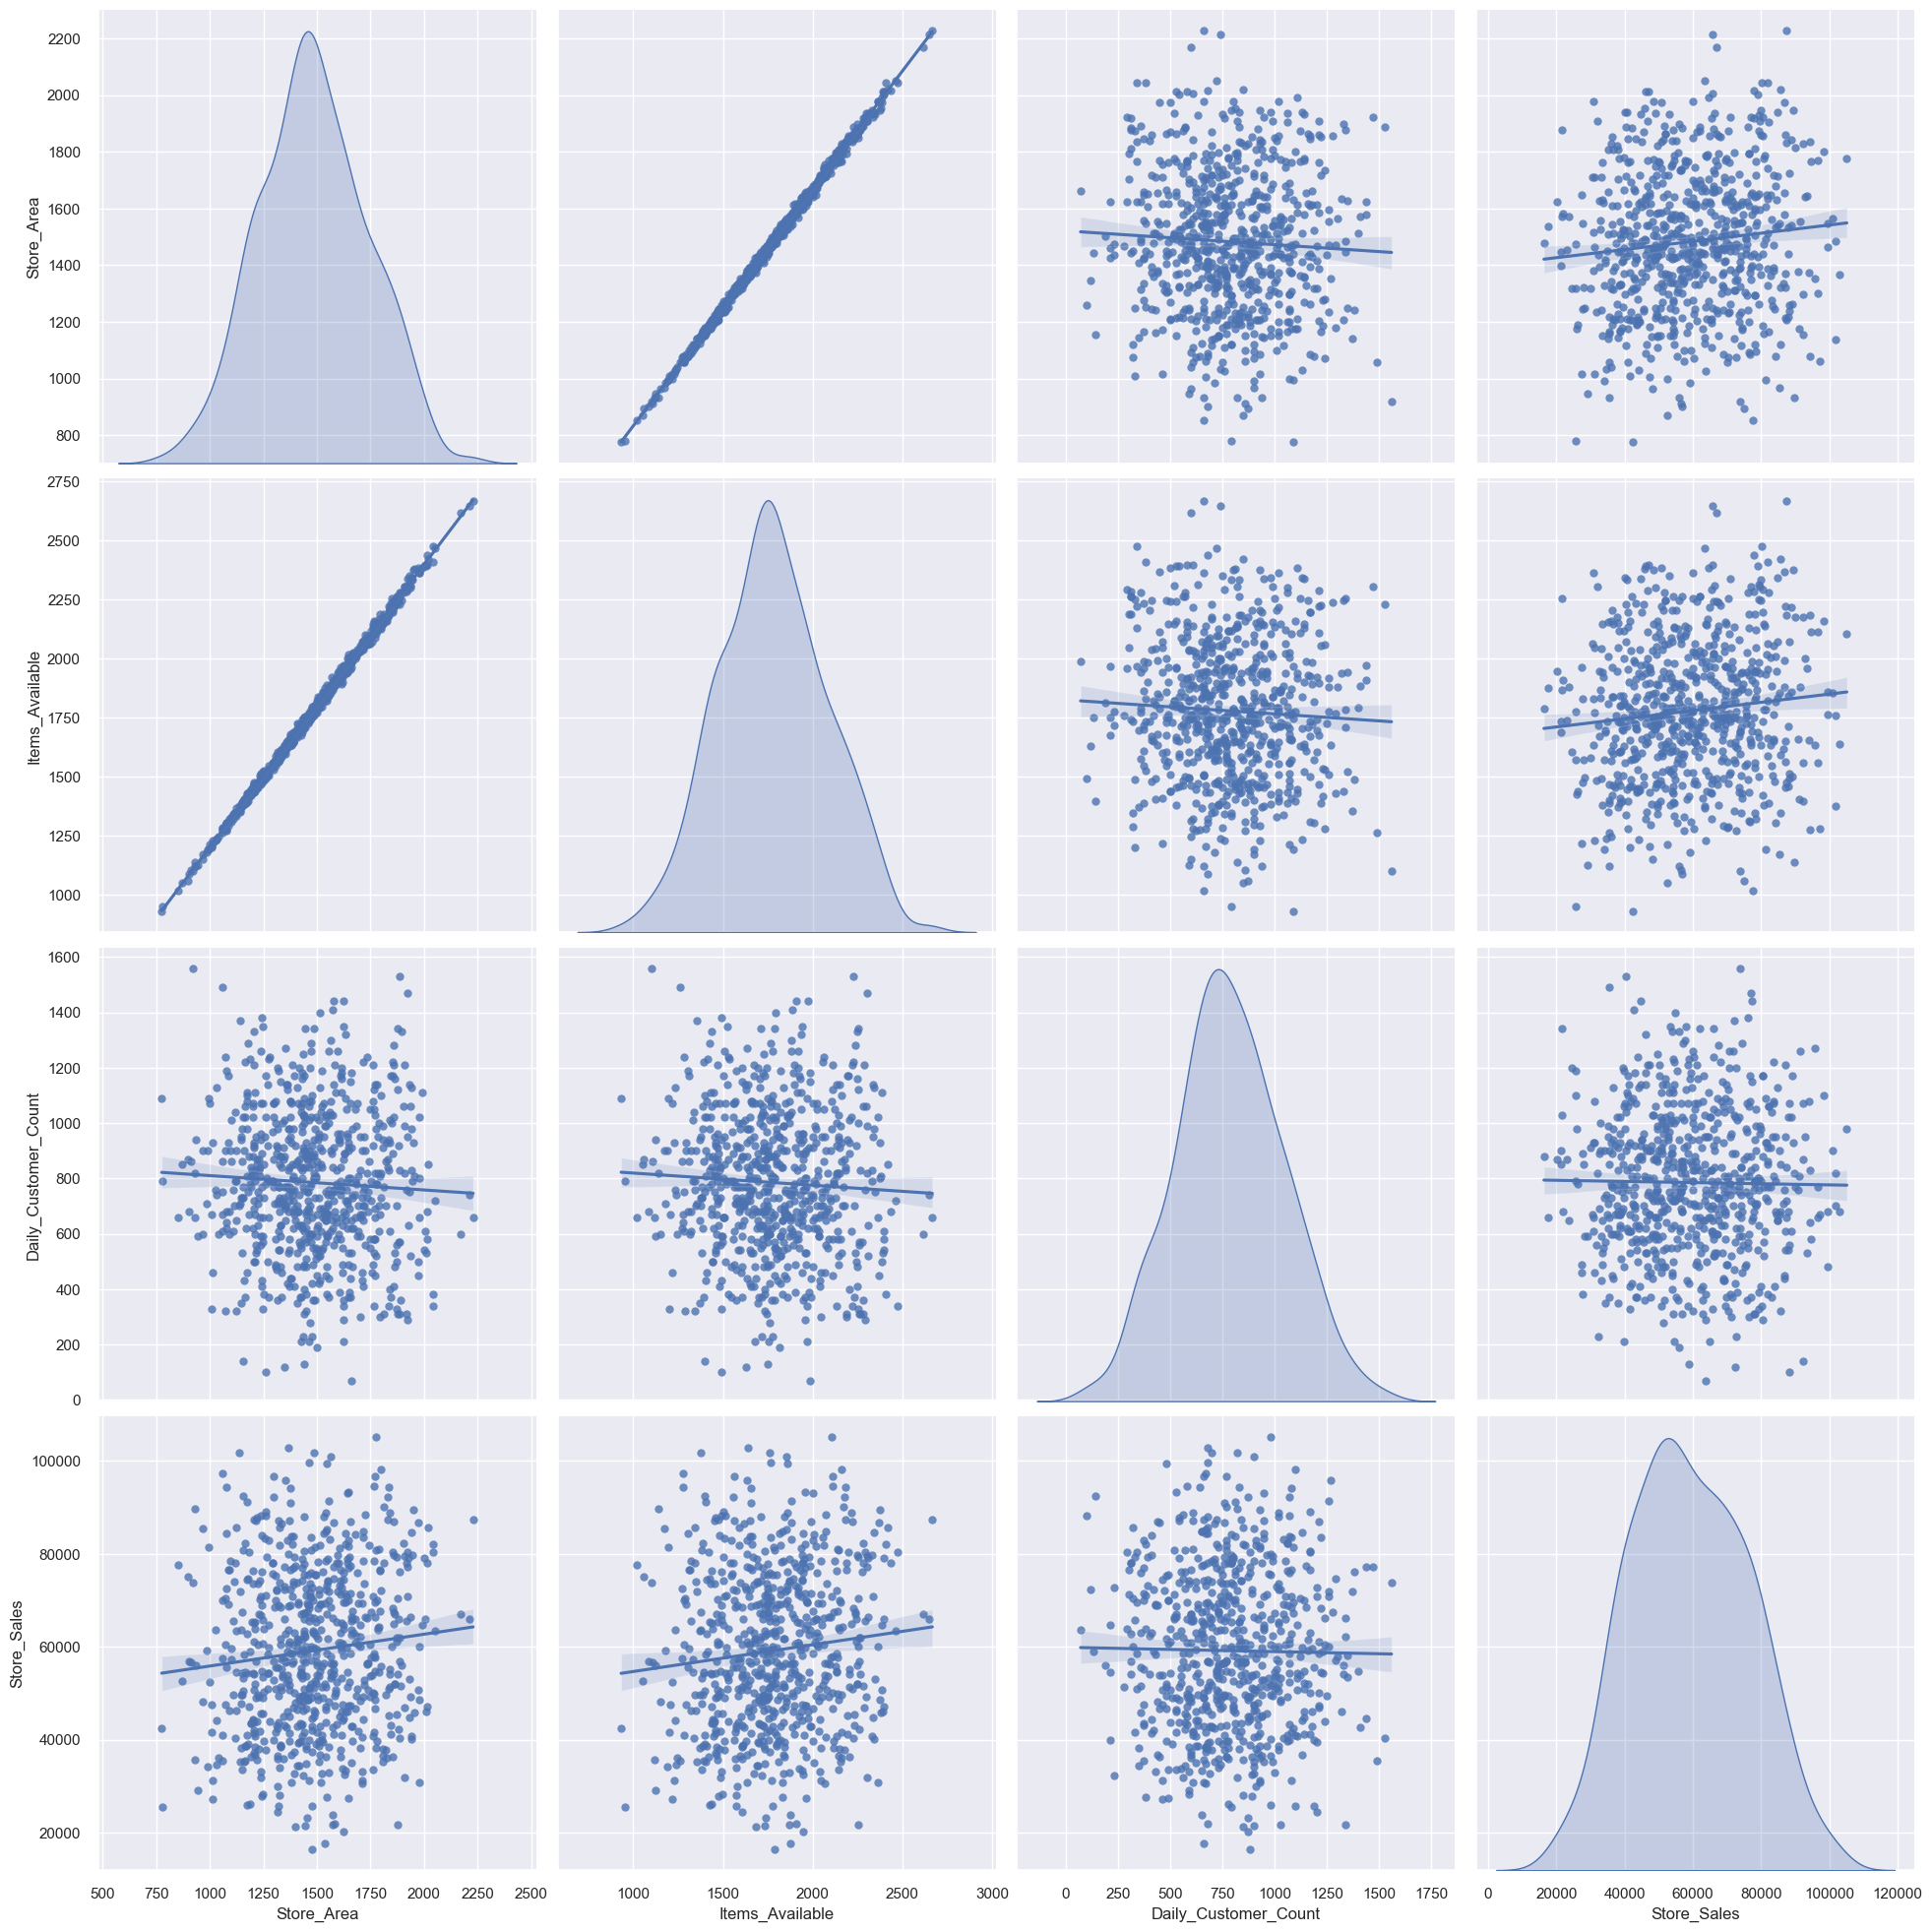

In [22]:
sns.set()
sns.pairplot(df_train.iloc[:,[1,2,3,4]],height = 5 ,kind ='reg',diag_kind='kde')
plt.show()

- A uma forte correlação entre Store_Area e Items_Available
- A correlações positivas fracas entre as variáveis Store_Area e Items_Available com a target Store_Sales

Dito isto será um desafio montar um modelo linear que consiga bons resultados com estas variáveis.

# Análise Univariada

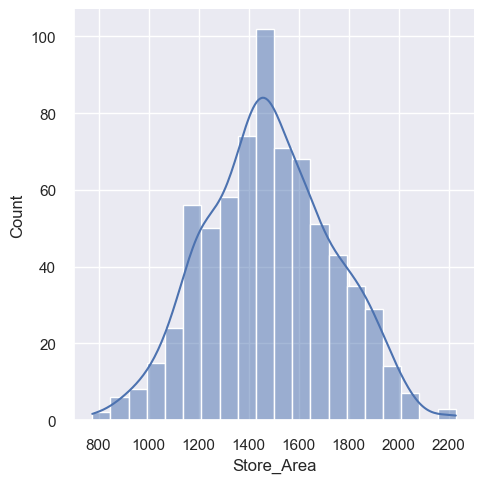

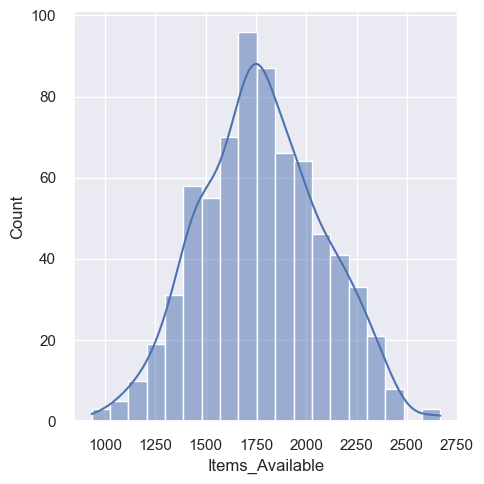

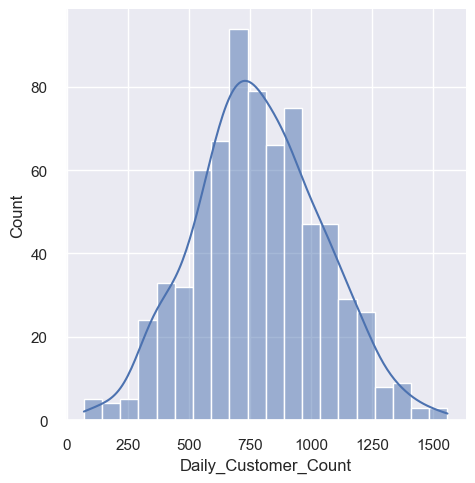

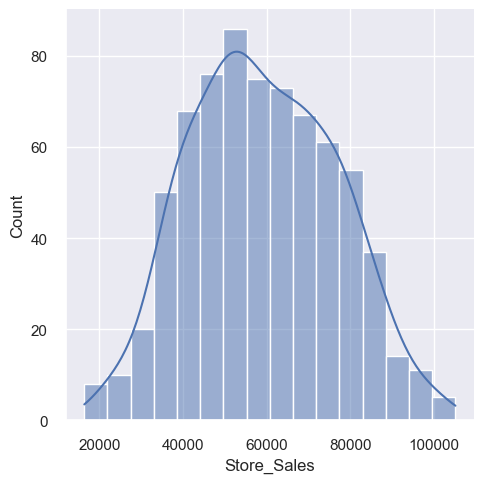

In [23]:
for col in df_train.iloc[:,[1,2,3,4]].columns.to_list():

    sns.displot(df_train[col], kde=True)

- Os gráficos apresentam as variáveis com as distribuições de dados em formato de sino, mas não tenho certeza se elas têm uma distribuição normal, para validar a premissa dos modelos lineares.
- Vou fazer alguns testes de hipóteses nestas variáveis para ter certeza !

In [24]:
from scipy import stats

In [25]:
def test_norm(data: pd.DataFrame):
    for col in data.columns:
        stat, p = stats.shapiro(data[col])
        print(f'Coluna {col}: Estatística de teste = {stat:.3f}, p-valor = {p:.3f}')

        if p > 0.05:
            print(f'Os dados da coluna {col} têm distribuição normal.')
        else:
            print(f'Os dados da coluna {col} não têm distribuição normal.')

In [26]:
test_norm(df_train.iloc[:,[1,2,3,4]])

Coluna Store_Area: Estatística de teste = 0.997, p-valor = 0.139
Os dados da coluna Store_Area têm distribuição normal.
Coluna Items_Available: Estatística de teste = 0.997, p-valor = 0.157
Os dados da coluna Items_Available têm distribuição normal.
Coluna Daily_Customer_Count: Estatística de teste = 0.998, p-valor = 0.390
Os dados da coluna Daily_Customer_Count têm distribuição normal.
Coluna Store_Sales: Estatística de teste = 0.992, p-valor = 0.001
Os dados da coluna Store_Sales não têm distribuição normal.


Por não termos uma distribuiçõ normal na target talvez precisaremos alterar sua natureza para facilitar a previsão dos algoritmos ou usar modelos robustos para estes tipos de dados 

# Baseline de média dos analistas nos dados de teste

In [27]:
# teste
df_teste = pd.read_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\test.csv', sep=',')

In [28]:
# Modelo  de média

# Calcular média de vendas 
mean_sales = np.mean(df_teste['Store_Sales'])

In [29]:
# Prever a média de vendas para cada loja
predictions = np.full(len(df_teste), mean_sales)

In [30]:
# Calcular erro baseline MAE RMSE MAPE

R2 = r2_score(df_teste['Store_Sales'], predictions) 
RMSE = np.sqrt(mean_squared_error(df_teste['Store_Sales'], predictions))
MAPE = mean_absolute_percentage_error(df_teste['Store_Sales'], predictions)

In [31]:
print(f"R2: {R2:.2f}")
print(f"RMSE: {RMSE:.2f}")
print(f"MAPE: {MAPE:.2%}")

R2: 0.00
RMSE: 16493.87
MAPE: 25.74%


    - O modelo de média tem um erro em torno de 25,74% 
    - Nosso objetivo será reduzir este erro

# Feature Engineering

# Modelagem - Machine Learning

## Treino/Validação

In [32]:
# Separar variáveis independentes e dependente
X = df_train.drop(['Store_Sales'], axis=1)
y = df_train['Store_Sales']

In [33]:
X.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count
0,737,1098,1309,860
1,383,1454,1737,870
2,707,1495,1793,1020
3,818,1608,1962,770
4,119,1500,1798,860


In [34]:
y

0      59530
1      23090
2      65300
3      36280
4      56710
       ...  
711    69310
712    26220
713    48950
714    52060
715    89080
Name: Store_Sales, Length: 716, dtype: int64

In [35]:
# definir função para treinar e validar os modelos e registrar os resultados dos experimentos

def train_validation_eval(model_name, model, X, y, gridsearch=False, params_grid=None, run_name=None, experiment_name=None, path_save_fig=None):
    
    
    logging.info("Função train_validation_eval iniciada")
    
    # listas de métricas para append futuro
    r2 = []
    rmse = []
    mape = []
    
    # inicializar variável best_model, best_param e default_params
    best_model = None
    best_param = None
    default_params = None
    
    logging.info("Iniciando loop de validação cruzada")
    # Cross validation
    n_splits = 5
    RdKFOLD = RepeatedKFold(n_splits=n_splits, n_repeats=2, random_state=42)
    fold = 0 
    
    # Split treino e validação hold out
    for train_ix, val_ix in RdKFOLD.split(X):
        
        fold+=1
        
        X_train, X_valid = X.iloc[train_ix, :], X.iloc[val_ix, :]
        y_train, y_valid = y.iloc[train_ix], y.iloc[val_ix]
        
        if gridsearch == False:
            logging.info(f"Treinando {model_name} com parâmetros padrão, fold {fold}")
            # Treino modelo default
            model.fit(X_train, y_train)
            logging.info(f"Prevendo conjunto de validação com {model_name} padrão, fold {fold}")
            # pegar parâtros default
            default_params = model.get_params()
            # Prever na validaçã
            yhat = model.predict(X_valid)
            
        else:
            logging.info(f"Treinando {model_name} com parâmetros otimizados pelo GridSearch, fold {fold}")
            # Definir espaço de gridsearch
            search = GridSearchCV(model, params_grid, scoring='neg_root_mean_squared_error', cv=RdKFOLD, n_jobs=-1)
            # Ajustar modelo
            search_result = search.fit(X_train, y_train) 
            # melhor parâmetro
            best_param = search_result.best_params_
            # melhor modelo
            best_model = search_result.best_estimator_
            logging.info(f"Prevendo conjunto de validação com {model_name} otimizado, fold {fold}")
            # Prever na validação com melhor modelo
            yhat = best_model.predict(X_valid)
        
        logging.info("Avaliando resultados nos dados de validação")
        #Avaliação numerica
        # R2
        R2 = r2_score(y_valid, yhat)
        r2.append(R2)
        # RMSE
        RMSE = np.sqrt(mean_squared_error(y_valid, yhat))
        rmse.append(RMSE)
        # MAPE
        MAPE = mean_absolute_percentage_error(y_valid, yhat)
        mape.append(MAPE)
        
    # Erro de previsão com a reta da regressão
    p = np.polyfit(y_valid, yhat, 1)
    plt.scatter(y_valid, yhat, alpha=0.5)
    plt.plot(y_valid, np.polyval(p, y_valid), color='red')
    plt.xlabel('Valor Real')
    plt.ylabel('Previsão')
    plt.title(f'Reta da Regressão para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
    
    # Resíduos dos erros
    residuals = y_valid - yhat
    plt.hist(residuals, bins=25)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Erros Resíduais para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()


        
    # Avaliação na validação
    print(f"Modelo:  {model_name}")
    print(f"R2 CV:   {np.mean(r2):.2f}")
    print(f"RMSE CV: {np.mean(rmse):.2f}")
    print(f"MAPE CV: {np.mean(mape)*100:.2f}%")
    
    if gridsearch == True:
        # Imprimir melhor parâmetro e modelo após o loop de validação cruzada
        print(f"Melhores parâmetros: {best_param}")
        print(f"Melhor modelo: {best_model}")
    
    logging.info("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    
    with mlflow.start_run(run_name=run_name):
        if best_param is not None:  
            mlflow.log_params(best_param)
        if default_params is not None:
            mlflow.log_params(default_params)
        mlflow.log_metric('R2 CV', np.mean(r2))
        mlflow.log_metric('RMSE CV', np.mean(rmse))
        mlflow.log_metric('MAPE CV', np.mean(mape))
        try:
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"))
        except:
            pass
        mlflow.sklearn.log_model(model, model_name)
    mlflow.end_run()
        
    return logging.info('Ciclo de vida dos modelos rastreado com sucesso!')


### Algoritmos do Sklearn

In [36]:
path_save_fig = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\reports\figures'

2023-04-12 21:09:38,319 - Função train_validation_eval iniciada
2023-04-12 21:09:38,320 - Iniciando loop de validação cruzada
2023-04-12 21:09:38,322 - Treinando LinearRegression com parâmetros padrão, fold 1
2023-04-12 21:09:38,327 - Prevendo conjunto de validação com LinearRegression padrão, fold 1
2023-04-12 21:09:38,329 - Avaliando resultados nos dados de validação
2023-04-12 21:09:38,331 - Treinando LinearRegression com parâmetros padrão, fold 2
2023-04-12 21:09:38,335 - Prevendo conjunto de validação com LinearRegression padrão, fold 2
2023-04-12 21:09:38,337 - Avaliando resultados nos dados de validação
2023-04-12 21:09:38,341 - Treinando LinearRegression com parâmetros padrão, fold 3
2023-04-12 21:09:38,345 - Prevendo conjunto de validação com LinearRegression padrão, fold 3
2023-04-12 21:09:38,349 - Avaliando resultados nos dados de validação
2023-04-12 21:09:38,352 - Treinando LinearRegression com parâmetros padrão, fold 4
2023-04-12 21:09:38,357 - Prevendo conjunto de valida

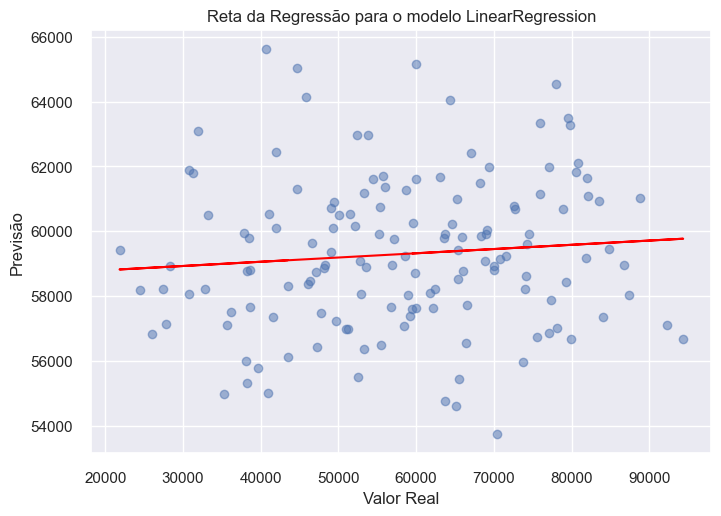

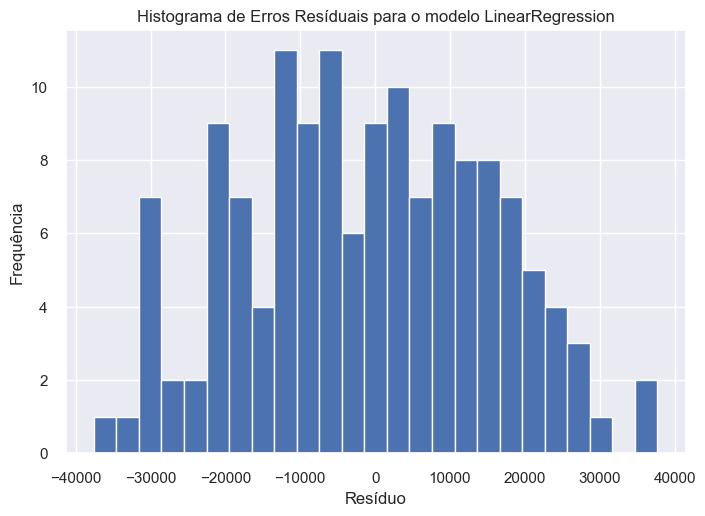

2023-04-12 21:09:39,225 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/12 21:09:39 INFO mlflow.tracking.fluent: Experiment with name 'Modelos do Sklearn com parâmetros padrão - treino e validação' does not exist. Creating a new experiment.


Modelo:  LinearRegression
R2 CV:   -0.00
RMSE CV: 17312.87
MAPE CV: 28.60%


2023-04-12 21:09:43,505 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-12 21:09:43,506 - Função train_validation_eval iniciada
2023-04-12 21:09:43,506 - Iniciando loop de validação cruzada
2023-04-12 21:09:43,510 - Treinando RandomForestRegressor com parâmetros padrão, fold 1
2023-04-12 21:09:43,773 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 1
2023-04-12 21:09:43,785 - Avaliando resultados nos dados de validação
2023-04-12 21:09:43,789 - Treinando RandomForestRegressor com parâmetros padrão, fold 2
2023-04-12 21:09:44,060 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 2
2023-04-12 21:09:44,070 - Avaliando resultados nos dados de validação
2023-04-12 21:09:44,073 - Treinando RandomForestRegressor com parâmetros padrão, fold 3
2023-04-12 21:09:44,357 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 3
2023-04-12 21:09:44,366 - Avaliando resultados nos dados de validação
2023-04-12 21:09:44,369 - Trein

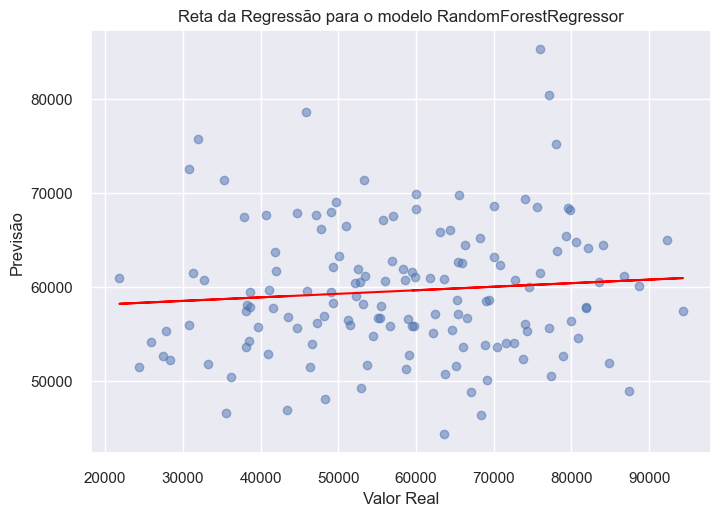

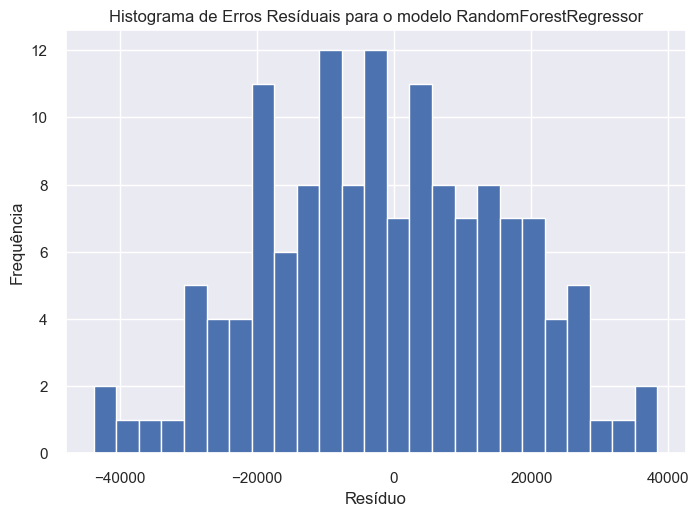

2023-04-12 21:09:47,048 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor
R2 CV:   -0.07
RMSE CV: 17849.01
MAPE CV: 29.25%


2023-04-12 21:09:51,331 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-12 21:09:51,332 - Função train_validation_eval iniciada
2023-04-12 21:09:51,333 - Iniciando loop de validação cruzada
2023-04-12 21:09:51,337 - Treinando Ridge com parâmetros padrão, fold 1
2023-04-12 21:09:51,343 - Prevendo conjunto de validação com Ridge padrão, fold 1
2023-04-12 21:09:51,346 - Avaliando resultados nos dados de validação
2023-04-12 21:09:51,349 - Treinando Ridge com parâmetros padrão, fold 2
2023-04-12 21:09:51,353 - Prevendo conjunto de validação com Ridge padrão, fold 2
2023-04-12 21:09:51,355 - Avaliando resultados nos dados de validação
2023-04-12 21:09:51,360 - Treinando Ridge com parâmetros padrão, fold 3
2023-04-12 21:09:51,363 - Prevendo conjunto de validação com Ridge padrão, fold 3
2023-04-12 21:09:51,365 - Avaliando resultados nos dados de validação
2023-04-12 21:09:51,369 - Treinando Ridge com parâmetros padrão, fold 4
2023-04-12 21:09:51,373 - Prevendo conjunto de validaçã

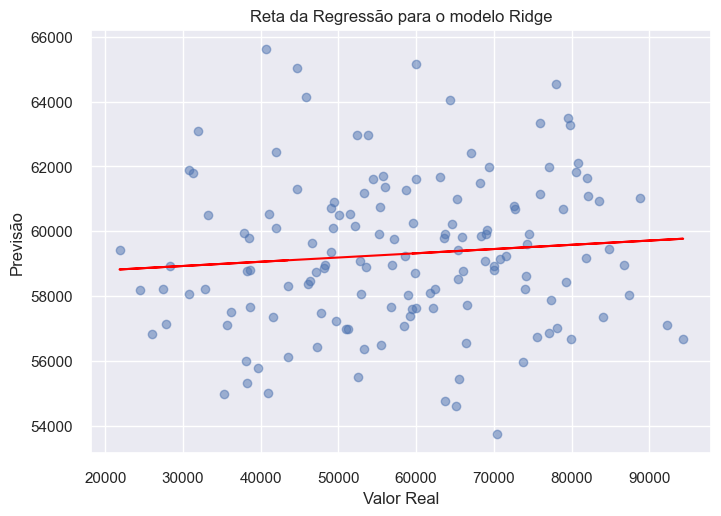

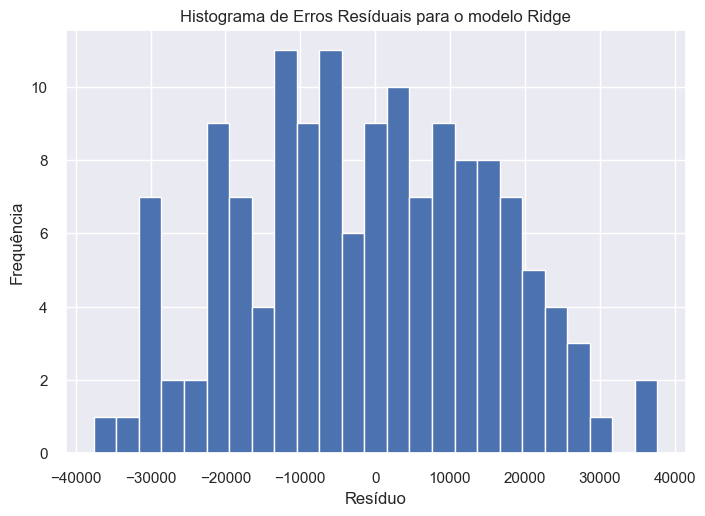

2023-04-12 21:09:52,255 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Ridge
R2 CV:   -0.00
RMSE CV: 17312.87
MAPE CV: 28.60%


2023-04-12 21:09:56,203 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-12 21:09:56,204 - Função train_validation_eval iniciada
2023-04-12 21:09:56,204 - Iniciando loop de validação cruzada
2023-04-12 21:09:56,209 - Treinando Lasso com parâmetros padrão, fold 1
2023-04-12 21:09:56,215 - Prevendo conjunto de validação com Lasso padrão, fold 1
2023-04-12 21:09:56,218 - Avaliando resultados nos dados de validação
2023-04-12 21:09:56,221 - Treinando Lasso com parâmetros padrão, fold 2
2023-04-12 21:09:56,225 - Prevendo conjunto de validação com Lasso padrão, fold 2
2023-04-12 21:09:56,228 - Avaliando resultados nos dados de validação
2023-04-12 21:09:56,233 - Treinando Lasso com parâmetros padrão, fold 3
2023-04-12 21:09:56,237 - Prevendo conjunto de validação com Lasso padrão, fold 3
2023-04-12 21:09:56,239 - Avaliando resultados nos dados de validação
2023-04-12 21:09:56,244 - Treinando Lasso com parâmetros padrão, fold 4
2023-04-12 21:09:56,248 - Prevendo conjunto de validaçã

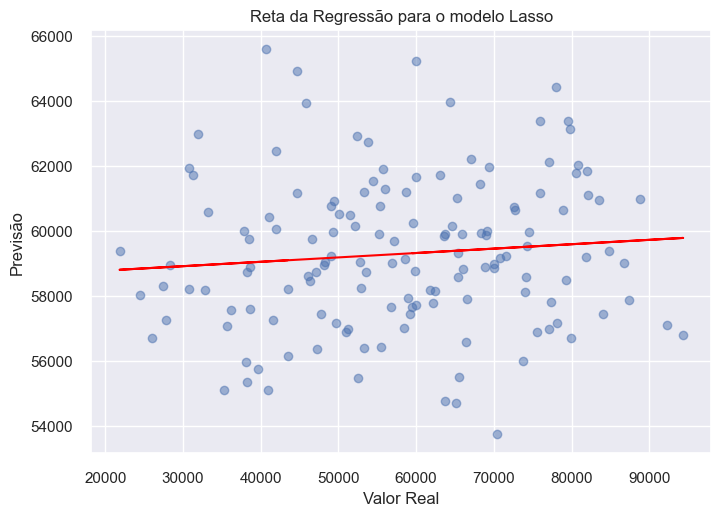

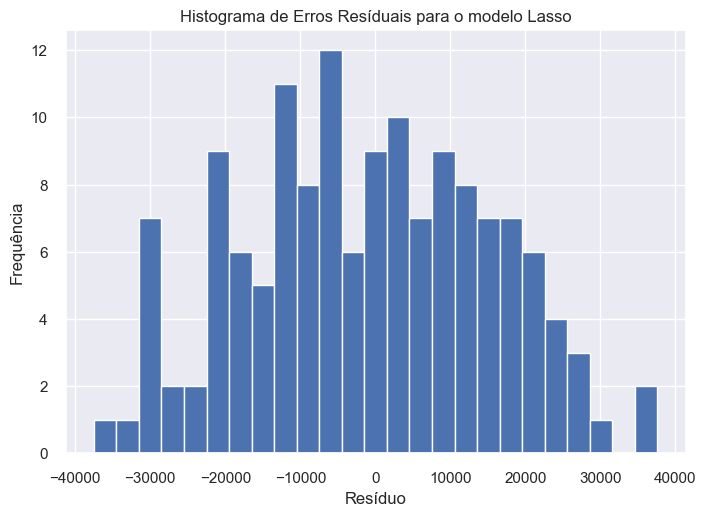

2023-04-12 21:09:57,386 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso
R2 CV:   -0.00
RMSE CV: 17306.07
MAPE CV: 28.59%


2023-04-12 21:10:01,421 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-12 21:10:01,423 - Função train_validation_eval iniciada
2023-04-12 21:10:01,423 - Iniciando loop de validação cruzada
2023-04-12 21:10:01,427 - Treinando ElasticNet com parâmetros padrão, fold 1
2023-04-12 21:10:01,431 - Prevendo conjunto de validação com ElasticNet padrão, fold 1
2023-04-12 21:10:01,434 - Avaliando resultados nos dados de validação
2023-04-12 21:10:01,439 - Treinando ElasticNet com parâmetros padrão, fold 2
2023-04-12 21:10:01,443 - Prevendo conjunto de validação com ElasticNet padrão, fold 2
2023-04-12 21:10:01,447 - Avaliando resultados nos dados de validação
2023-04-12 21:10:01,451 - Treinando ElasticNet com parâmetros padrão, fold 3
2023-04-12 21:10:01,455 - Prevendo conjunto de validação com ElasticNet padrão, fold 3
2023-04-12 21:10:01,458 - Avaliando resultados nos dados de validação
2023-04-12 21:10:01,463 - Treinando ElasticNet com parâmetros padrão, fold 4
2023-04-12 21:10:01,

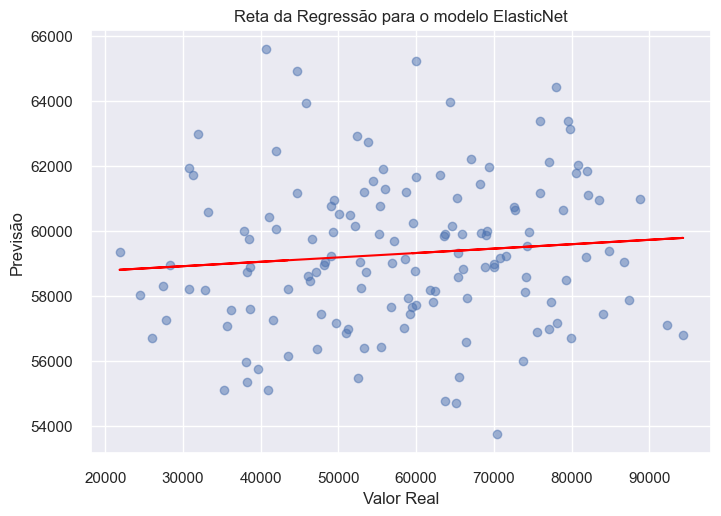

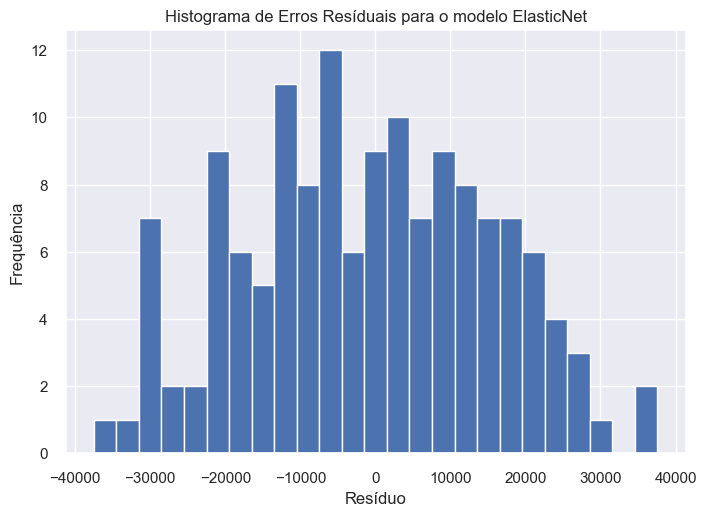

2023-04-12 21:10:02,344 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  ElasticNet
R2 CV:   -0.00
RMSE CV: 17305.86
MAPE CV: 28.59%


2023-04-12 21:10:06,315 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-12 21:10:06,317 - Função train_validation_eval iniciada
2023-04-12 21:10:06,317 - Iniciando loop de validação cruzada
2023-04-12 21:10:06,320 - Treinando SVR com parâmetros padrão, fold 1
2023-04-12 21:10:06,333 - Prevendo conjunto de validação com SVR padrão, fold 1
2023-04-12 21:10:06,343 - Avaliando resultados nos dados de validação
2023-04-12 21:10:06,346 - Treinando SVR com parâmetros padrão, fold 2
2023-04-12 21:10:06,359 - Prevendo conjunto de validação com SVR padrão, fold 2
2023-04-12 21:10:06,367 - Avaliando resultados nos dados de validação
2023-04-12 21:10:06,371 - Treinando SVR com parâmetros padrão, fold 3
2023-04-12 21:10:06,384 - Prevendo conjunto de validação com SVR padrão, fold 3
2023-04-12 21:10:06,392 - Avaliando resultados nos dados de validação
2023-04-12 21:10:06,396 - Treinando SVR com parâmetros padrão, fold 4
2023-04-12 21:10:06,407 - Prevendo conjunto de validação com SVR padr

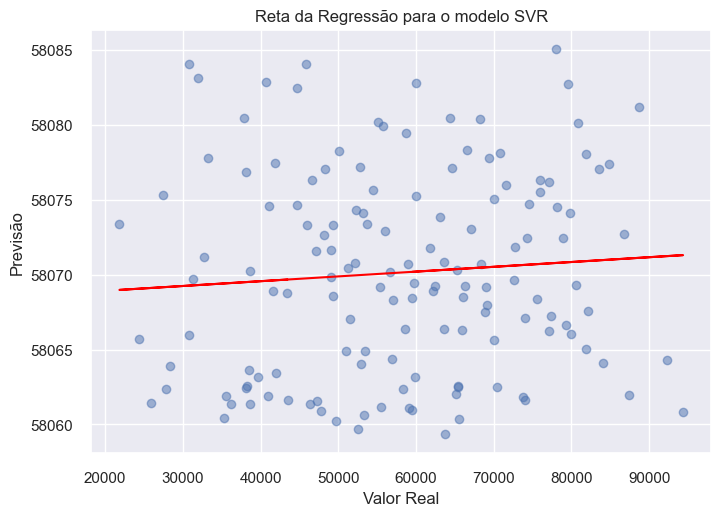

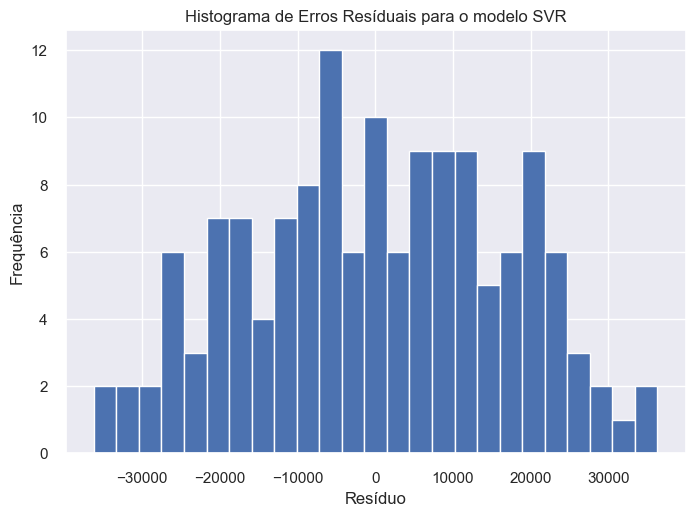

2023-04-12 21:10:07,305 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  SVR
R2 CV:   -0.01
RMSE CV: 17391.48
MAPE CV: 28.28%


2023-04-12 21:10:11,344 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-12 21:10:11,345 - Função train_validation_eval iniciada
2023-04-12 21:10:11,346 - Iniciando loop de validação cruzada
2023-04-12 21:10:11,349 - Treinando MLPRegressor com parâmetros padrão, fold 1
2023-04-12 21:10:11,860 - Prevendo conjunto de validação com MLPRegressor padrão, fold 1
2023-04-12 21:10:11,862 - Avaliando resultados nos dados de validação
2023-04-12 21:10:11,867 - Treinando MLPRegressor com parâmetros padrão, fold 2
2023-04-12 21:10:12,433 - Prevendo conjunto de validação com MLPRegressor padrão, fold 2
2023-04-12 21:10:12,436 - Avaliando resultados nos dados de validação
2023-04-12 21:10:12,439 - Treinando MLPRegressor com parâmetros padrão, fold 3
2023-04-12 21:10:13,008 - Prevendo conjunto de validação com MLPRegressor padrão, fold 3
2023-04-12 21:10:13,011 - Avaliando resultados nos dados de validação
2023-04-12 21:10:13,014 - Treinando MLPRegressor com parâmetros padrão, fold 4
2023-0

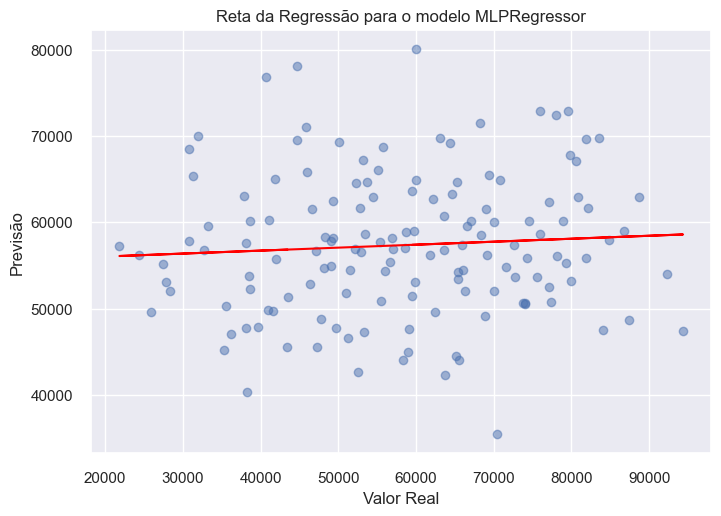

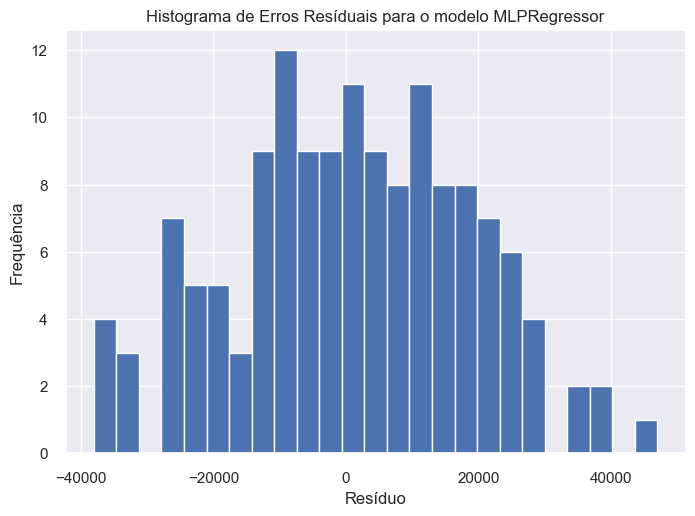

2023-04-12 21:10:17,978 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  MLPRegressor
R2 CV:   -0.14
RMSE CV: 18408.15
MAPE CV: 28.94%


2023-04-12 21:10:21,706 - Ciclo de vida dos modelos rastreado com sucesso!


In [38]:
# definir lista de algoritmos a serem testados
algoritmos = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('SVR', SVR()),
    ('MLPRegressor', MLPRegressor())
]

experiment_name = 'Modelos do Sklearn com parâmetros padrão - treino e validação'

# Treinar e validar os vários algoritmos acima:
for model_name, model in algoritmos:
    
    # Executar função sem GridSearch
    date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    model_name_date = model_name + ' - ' + date
    
    train_validation_eval(model_name=model_name, model=model, X=X, y=y, gridsearch=False, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

-  Avaliando os resultados no MLflow o modelo ElasticNet obteve o melhor resultado dentre os algoritmos do sklearn.
- Irei otimizalo para verificar se consigo obter um resultado mais razoável

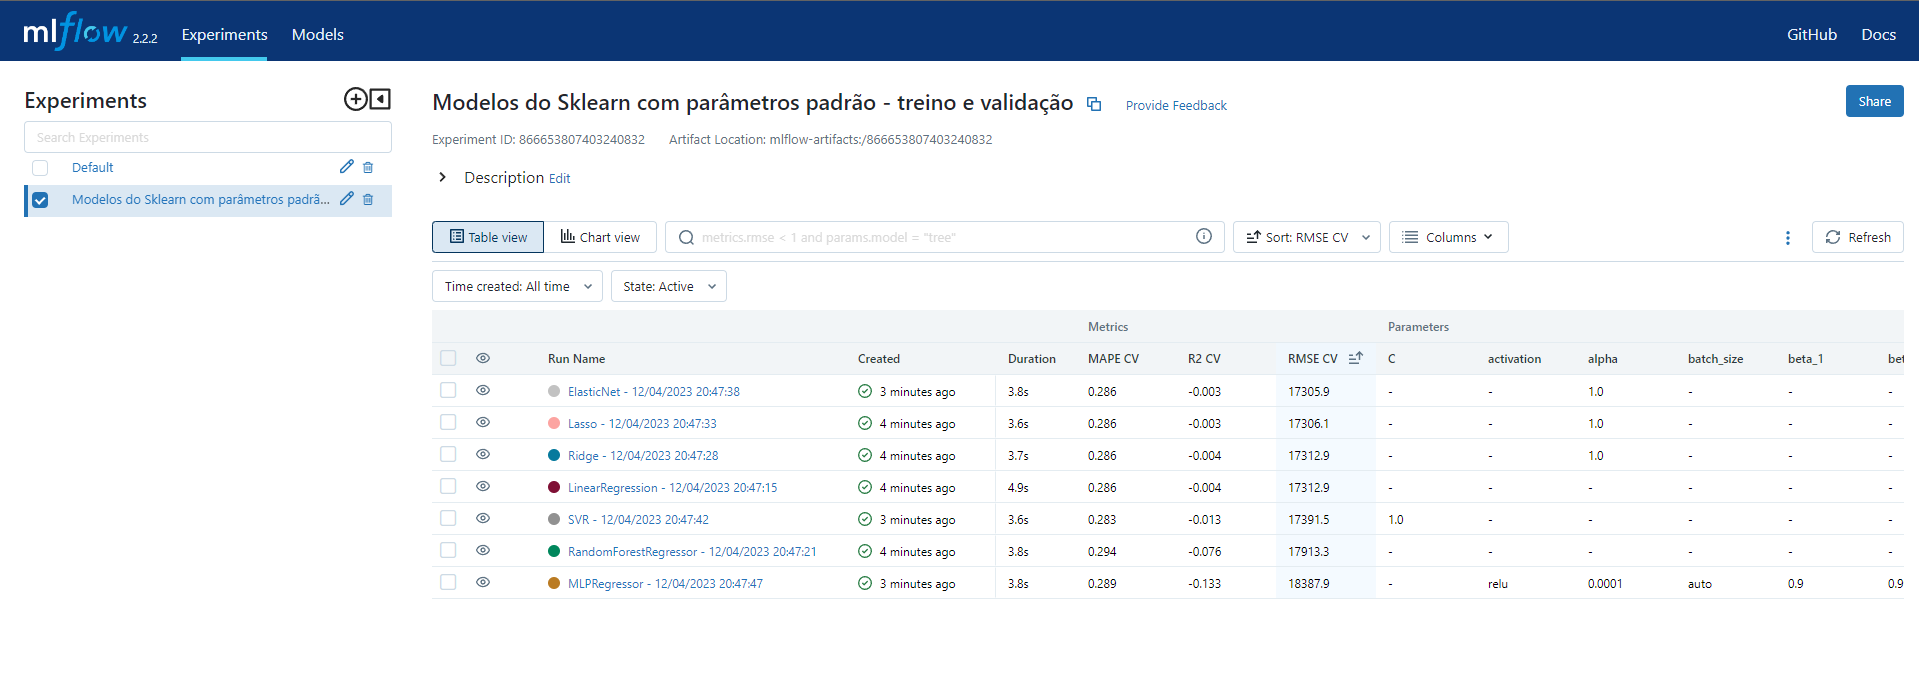

2023-04-12 21:10:21,719 - Função train_validation_eval iniciada
2023-04-12 21:10:21,721 - Iniciando loop de validação cruzada
2023-04-12 21:10:21,726 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 1
2023-04-12 21:10:29,657 - Prevendo conjunto de validação com ElasticNet otimizado, fold 1
2023-04-12 21:10:29,658 - Avaliando resultados nos dados de validação
2023-04-12 21:10:29,662 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 2
2023-04-12 21:10:31,774 - Prevendo conjunto de validação com ElasticNet otimizado, fold 2
2023-04-12 21:10:31,775 - Avaliando resultados nos dados de validação
2023-04-12 21:10:31,778 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 3
2023-04-12 21:10:33,907 - Prevendo conjunto de validação com ElasticNet otimizado, fold 3
2023-04-12 21:10:33,909 - Avaliando resultados nos dados de validação
2023-04-12 21:10:33,912 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 4
2023-0

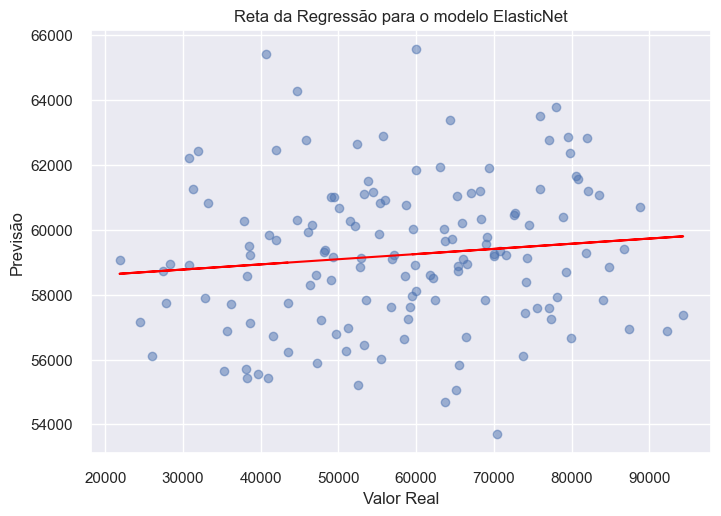

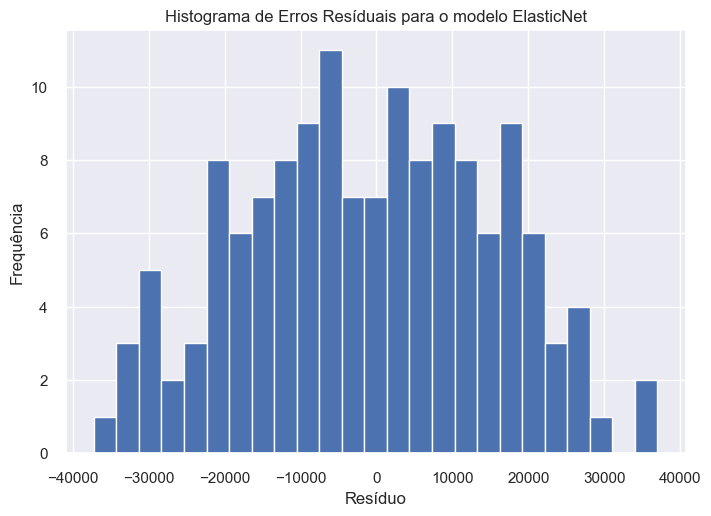

2023-04-12 21:10:50,957 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/12 21:10:50 INFO mlflow.tracking.fluent: Experiment with name 'Modelos do Sklearn com hiperparâmetros tunados - treino e validação' does not exist. Creating a new experiment.


Modelo:  ElasticNet
R2 CV:   0.00
RMSE CV: 17272.01
MAPE CV: 28.54%
Melhores parâmetros: {'alpha': 2.0, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 100, 'tol': 0.001}
Melhor modelo: ElasticNet(alpha=2.0, l1_ratio=0.1, max_iter=100, tol=0.001)


2023-04-12 21:10:54,621 - Ciclo de vida dos modelos rastreado com sucesso!


In [39]:
# definir algoritmo a ser otimizado
Elastic = ElasticNet()

# define os hiperparâmetros a serem testados
params = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [100, 500, 1000],
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False]
}

experiment_name = 'Modelos do Sklearn com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'ElasticNet'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=Elastic, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-12 21:10:54,637 - Função train_validation_eval iniciada
2023-04-12 21:10:54,638 - Iniciando loop de validação cruzada
2023-04-12 21:10:54,642 - Treinando Elastic_opt com parâmetros padrão, fold 1
2023-04-12 21:10:54,646 - Prevendo conjunto de validação com Elastic_opt padrão, fold 1
2023-04-12 21:10:54,650 - Avaliando resultados nos dados de validação
2023-04-12 21:10:54,654 - Treinando Elastic_opt com parâmetros padrão, fold 2
2023-04-12 21:10:54,658 - Prevendo conjunto de validação com Elastic_opt padrão, fold 2
2023-04-12 21:10:54,661 - Avaliando resultados nos dados de validação
2023-04-12 21:10:54,663 - Treinando Elastic_opt com parâmetros padrão, fold 3
2023-04-12 21:10:54,666 - Prevendo conjunto de validação com Elastic_opt padrão, fold 3
2023-04-12 21:10:54,668 - Avaliando resultados nos dados de validação
2023-04-12 21:10:54,673 - Treinando Elastic_opt com parâmetros padrão, fold 4
2023-04-12 21:10:54,676 - Prevendo conjunto de validação com Elastic_opt padrão, fold 4


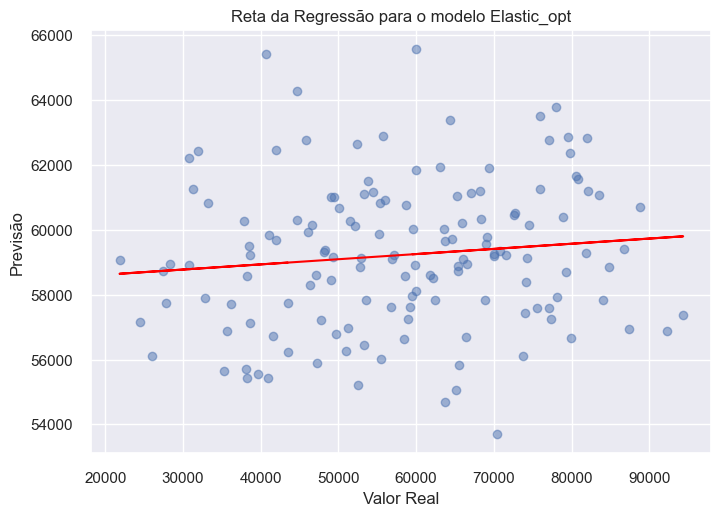

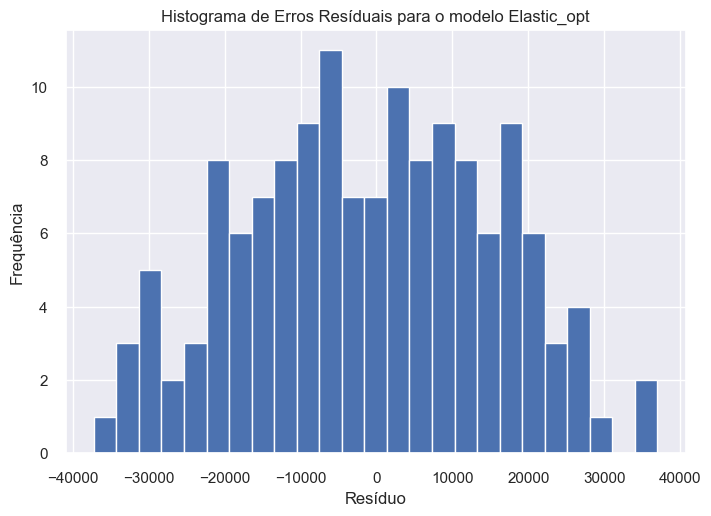

2023-04-12 21:10:55,494 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Elastic_opt
R2 CV:   0.00
RMSE CV: 17272.01
MAPE CV: 28.54%


2023-04-12 21:10:59,182 - Ciclo de vida dos modelos rastreado com sucesso!


CPU times: total: 594 ms
Wall time: 4.55 s


In [40]:
%%time
# Retreinando modelo otimizado com novos hiperparâmetros
Elastic_opt = ElasticNet(alpha=2.0, l1_ratio=0.1, fit_intercept=True, max_iter=100, tol=0.001)

experiment_name = 'Modelos do Sklearn com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Elastic_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=Elastic_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

- Não Houve uma melhora expressiva nos resultados mesmo com a otimização !

2023-04-12 21:41:20,652 - Função train_validation_eval iniciada
2023-04-12 21:41:20,654 - Iniciando loop de validação cruzada
2023-04-12 21:41:20,658 - Treinando RandomForestRegressor_opt com parâmetros otimizados pelo GridSearch, fold 1
2023-04-12 21:44:16,954 - Prevendo conjunto de validação com RandomForestRegressor_opt otimizado, fold 1
2023-04-12 21:44:16,975 - Avaliando resultados nos dados de validação
2023-04-12 21:44:16,979 - Treinando RandomForestRegressor_opt com parâmetros otimizados pelo GridSearch, fold 2
2023-04-12 21:47:47,348 - Prevendo conjunto de validação com RandomForestRegressor_opt otimizado, fold 2
2023-04-12 21:47:47,357 - Avaliando resultados nos dados de validação
2023-04-12 21:47:47,360 - Treinando RandomForestRegressor_opt com parâmetros otimizados pelo GridSearch, fold 3
2023-04-12 21:50:37,381 - Prevendo conjunto de validação com RandomForestRegressor_opt otimizado, fold 3
2023-04-12 21:50:37,390 - Avaliando resultados nos dados de validação
2023-04-12 21

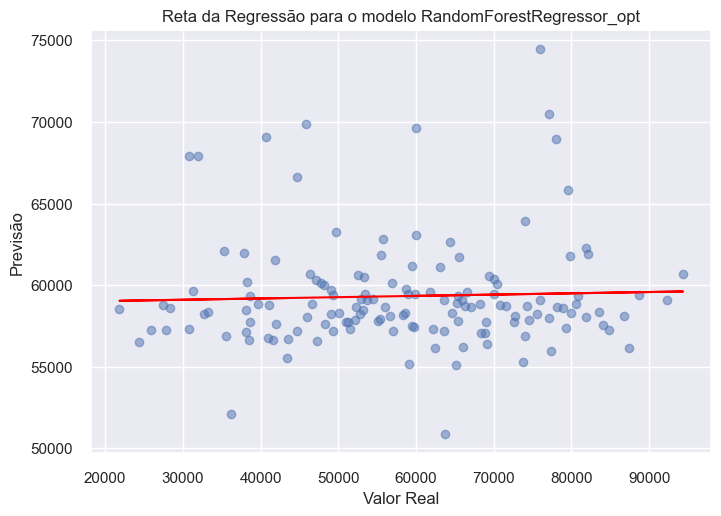

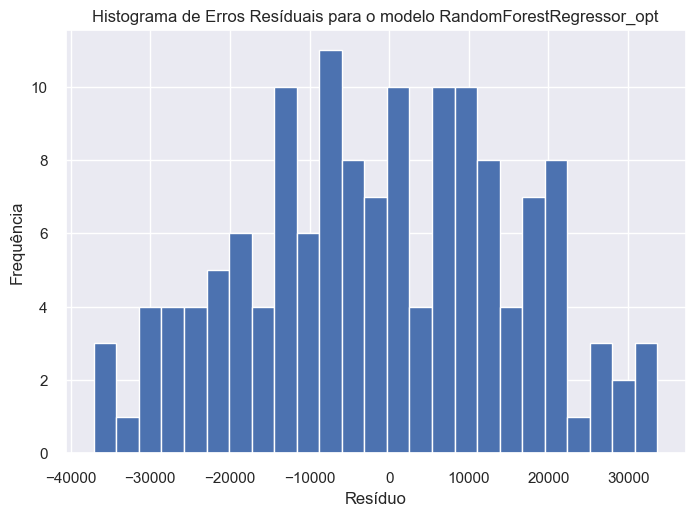

2023-04-12 22:20:23,657 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor_opt
R2 CV:   -0.01
RMSE CV: 17382.96
MAPE CV: 28.77%
Melhores parâmetros: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Melhor modelo: RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=200,
                      random_state=42)


2023-04-12 22:20:28,331 - Ciclo de vida dos modelos rastreado com sucesso!


In [46]:
# Testar otimizar a RandomForest
# definir algoritmo a ser otimizado
rfr_opt = RandomForestRegressor(random_state=42)

# define os hiperparâmetros a serem testados
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

experiment_name = 'Modelos do Sklearn com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=rfr_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-12 22:28:23,193 - Função train_validation_eval iniciada
2023-04-12 22:28:23,195 - Iniciando loop de validação cruzada
2023-04-12 22:28:23,197 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 1
2023-04-12 22:28:23,435 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 1
2023-04-12 22:28:23,451 - Avaliando resultados nos dados de validação
2023-04-12 22:28:23,453 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 2
2023-04-12 22:28:23,683 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 2
2023-04-12 22:28:23,698 - Avaliando resultados nos dados de validação
2023-04-12 22:28:23,702 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 3
2023-04-12 22:28:23,939 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 3
2023-04-12 22:28:23,954 - Avaliando resultados nos dados de validação
2023-04-12 22:28:23,957 - Treinando RandomForestRegressor_opt com parâmetros padrã

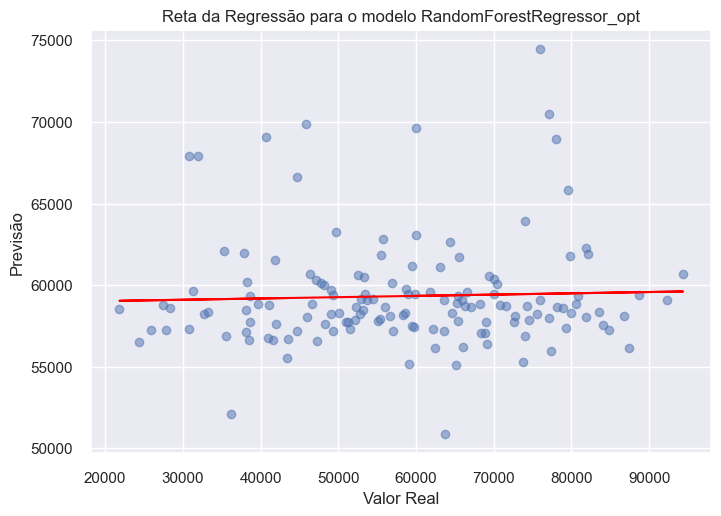

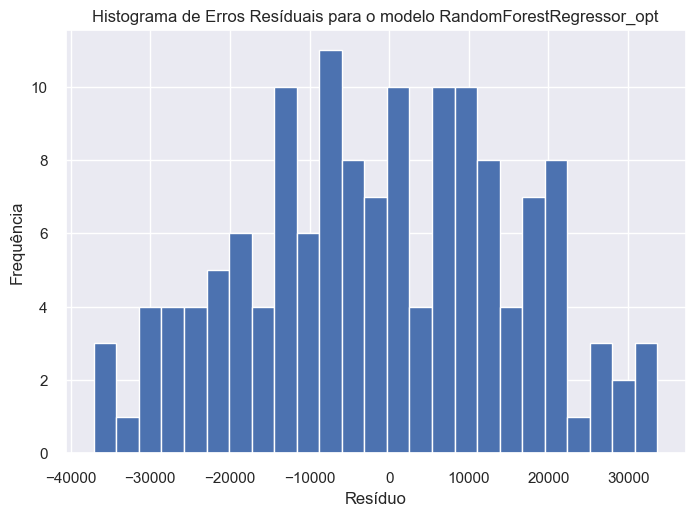

2023-04-12 22:28:26,461 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor_opt
R2 CV:   -0.01
RMSE CV: 17330.37
MAPE CV: 28.67%


2023-04-12 22:28:30,172 - Ciclo de vida dos modelos rastreado com sucesso!


In [47]:
# Retreinando modelo otimizado com novos hiperparâmetros
rfr_opt = RandomForestRegressor(bootstrap=True, max_depth=5, max_features='sqrt', n_estimators=200, random_state=42, min_samples_leaf=1, min_samples_split=2)

experiment_name = 'Modelos do Sklearn com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=rfr_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

## Teste

In [41]:
# Separar variáveis independentes e dependente
X_test = df_teste.drop(['Store_Sales'], axis=1)
y_test = df_teste['Store_Sales']

In [42]:
X_test.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count
0,712,1360,1612,490
1,441,1721,2076,710
2,526,1001,1194,1210
3,723,1799,2173,910
4,40,1270,1516,10


In [43]:
y_test

0      61080
1      76300
2      44890
3      36280
4      45480
       ...  
175    65970
176    70050
177    90180
178    71280
179    81470
Name: Store_Sales, Length: 180, dtype: int64

In [44]:
# definir função de avaliação para conjunto de teste
def test_eval(model_name, model, X_test, y_test, run_name=None, experiment_name=None, path_save_fig=None):
    
    logging.info("Prevendo conjunto de teste com modelo treinado")
    # Usar modelo treinado para previsão no conjunto de teste
    yhat = model.predict(X_test)
    
    logging.info("Avaliando resultados nos dados de teste")
    #Avaliação
    # R2
    R2 = r2_score(y_test, yhat)
    # RMSE
    RMSE = np.sqrt(mean_squared_error(y_test, yhat))
    # MAPE
    MAPE = mean_absolute_percentage_error(y_test, yhat)
    
    # Erro de previsão com a reta da regressão
    p = np.polyfit(y_test, yhat, 1)
    plt.scatter(y_test, yhat, alpha=0.5)
    plt.plot(y_test, np.polyval(p, y_test), color='red')
    plt.xlabel('Valor Real')
    plt.ylabel('Previsão')
    plt.title(f'Reta da Regressão para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
    
    # Resíduos dos erros
    residuals = y_test - yhat
    plt.hist(residuals, bins=25)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Erros Resíduais para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
   
        
    # Avaliação na validação
    print(f"Modelo: {model_name}")
    print(f"R2:     {R2:.2f}")
    print(f"RMSE:   {RMSE:.2f}")
    print(f"MAPE:   {MAPE:.2%}")
    
    logging.info("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_metric('R2', R2)
        mlflow.log_metric('RMSE', RMSE)
        mlflow.log_metric('MAPE', MAPE)
        mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
        mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"))
        mlflow.sklearn.log_model(model, model_name)
    mlflow.end_run()
        
    return logging.info('Ciclo de vida do modelo rastreado com sucesso!')
    

### Modelo ElasticNet otimizado

2023-04-12 21:10:59,255 - Prevendo conjunto de teste com modelo treinado
2023-04-12 21:10:59,258 - Avaliando resultados nos dados de teste


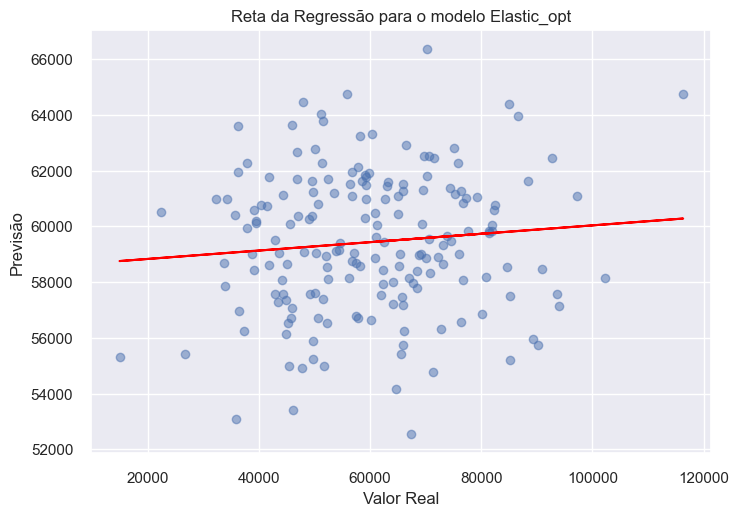

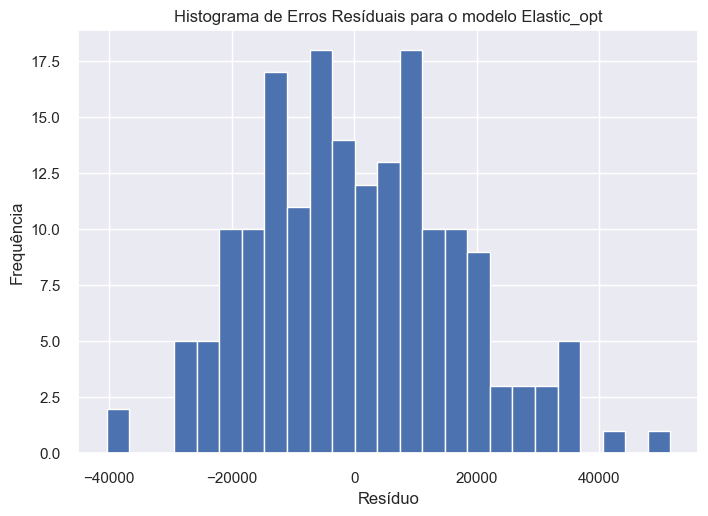

2023-04-12 21:10:59,979 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/12 21:10:59 INFO mlflow.tracking.fluent: Experiment with name 'Melhor modelo apresentado do Sklearn - teste' does not exist. Creating a new experiment.


Modelo: Elastic_opt
R2:     0.01
RMSE:   16449.77
MAPE:   25.37%


2023-04-12 21:11:03,605 - Ciclo de vida do modelo rastreado com sucesso!


In [45]:
# Melhor modelo apresentado do Sklearn

experiment_name = 'Melhor modelo apresentado do Sklearn - teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Elastic_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=Elastic_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

- O resultado obtido no teste já é melhor do quê o baseline.
    - Baseline MAPE = 25.74%
    - ElasticNet otimizado MAPE = 25.37%
- Porém este resultado não é aceitável para ir ao deploy !

    - Algumas estratégias técnicas para testar e buscar melhorar os resultados:
        - Transformação logarítmica na target
        - Escalonamento nas variáveis independentes (modelos de arvore não sofrerão alterações de resultados quanto a esta técnica)
        - Criar novas features
        - Otimizar outros modelos nos dados de validação
        - Modelar o problema com atributos polinomiais

### RandomForestRegressor otimizado

2023-04-12 22:31:44,445 - Prevendo conjunto de teste com modelo treinado
2023-04-12 22:31:44,462 - Avaliando resultados nos dados de teste


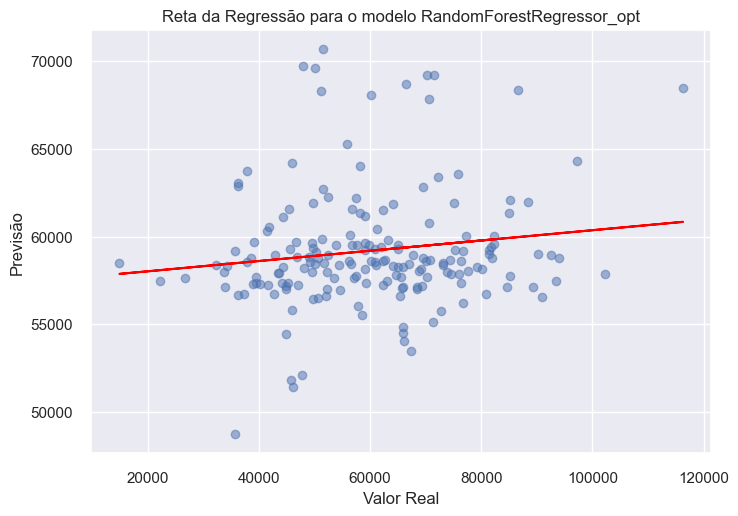

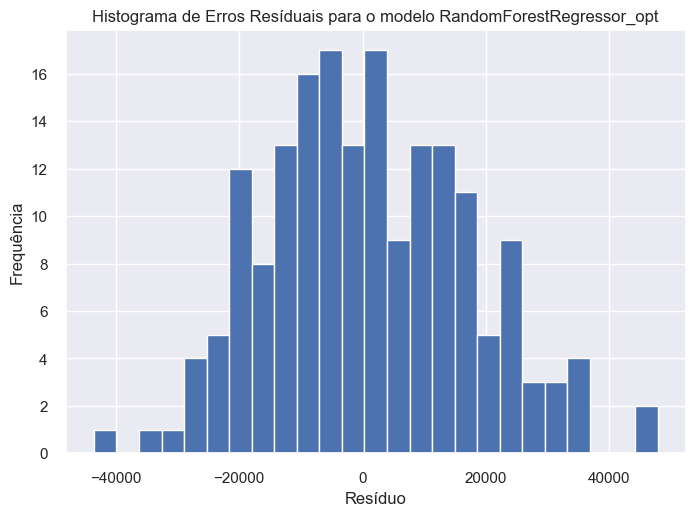

2023-04-12 22:31:45,168 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: RandomForestRegressor_opt
R2:     0.01
RMSE:   16380.27
MAPE:   25.21%


2023-04-12 22:31:49,096 - Ciclo de vida do modelo rastreado com sucesso!


In [48]:
experiment_name = 'Melhor modelo apresentado do Sklearn - teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=rfr_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

- O RandomForest se provou melhor otimizado e com resultado superior ao baseline e ao ElasticNet
- Porém ainda não estou satisfeito com os resultados.

# Avaliação - ROI

# Deploy